In [51]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import random
import math
import pickle

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,8)

# Estadísticos
# ------------------------------------------------------------------------------

from scipy import stats
import researchpy as rp
from scipy.stats import levene
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm


# Para la gestión de los warning
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')




### ASUNCIONES

In [52]:
df_bikes= pd.read_pickle("../data/outliers_gestion.pkl")
df_bikes.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,2018-01-01,Invierno,2018,enero,0,lunes,0,2,18.18125,80.5833,10.749882,331,654,985
1,2018-01-02,Invierno,2018,enero,0,martes,0,2,17.68695,69.6087,16.652113,131,670,801


Vamos comprobar la normalidad de nuestras variables respuestas para los dos modelos.

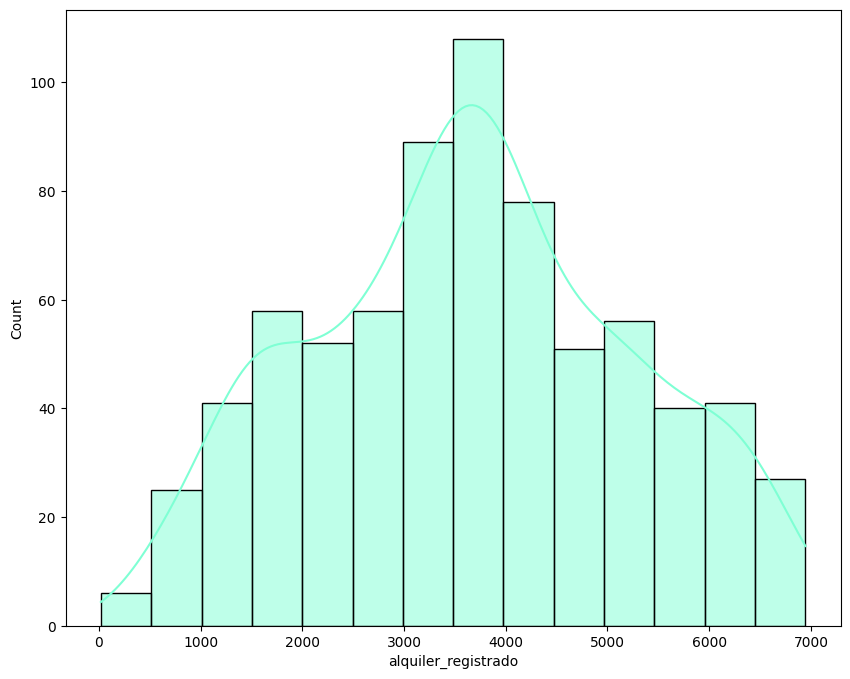

In [53]:
#Variable respuesta modelo I: 'alquiler_registrado'

sns.histplot(df_bikes["alquiler_registrado"], kde = True, color = "aquamarine");

In [54]:
stats.shapiro(df_bikes["alquiler_registrado"])

ShapiroResult(statistic=0.9843854308128357, pvalue=5.023125027037167e-07)

Raíz-cuadrada porque tenemos sesgo a la derecha

In [55]:
#Probamos de normalizar 'alquiler_registrado' con la raiz cuadrada, ya que está muy sesgada a la izquierda

df_bikes["alquiler_registrado_raiz"] = df_bikes["alquiler_registrado"].apply(lambda x: math.sqrt(x))
df_bikes.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_registrado_raiz
0,2018-01-01,Invierno,2018,enero,0,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,25.573424
1,2018-01-02,Invierno,2018,enero,0,martes,0,2,17.68695,69.6087,16.652113,131,670,801,25.884358


In [56]:
#comprobamos con el shapiro si se han normalizado los datos 

stats.shapiro(df_bikes["alquiler_registrado_raiz"])

ShapiroResult(statistic=0.9734112620353699, pvalue=2.976442425861592e-10)

In [57]:
#probamos a normalizar la variable con box-cox

df_bikes['alquiler_registrado_boxcox'], lambda_ajustada = stats.boxcox(df_bikes['alquiler_registrado'])
df_bikes.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_registrado_raiz,alquiler_registrado_boxcox
0,2018-01-01,Invierno,2018,enero,0,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,25.573424,267.555885
1,2018-01-02,Invierno,2018,enero,0,martes,0,2,17.68695,69.6087,16.652113,131,670,801,25.884358,273.035135


In [58]:
stats.shapiro(df_bikes["alquiler_registrado_boxcox"])

ShapiroResult(statistic=0.9854223132133484, pvalue=1.163151068794832e-06)

Podemos visualizar la diferencia entre los datos normalizados y sin normalizar con un distplot

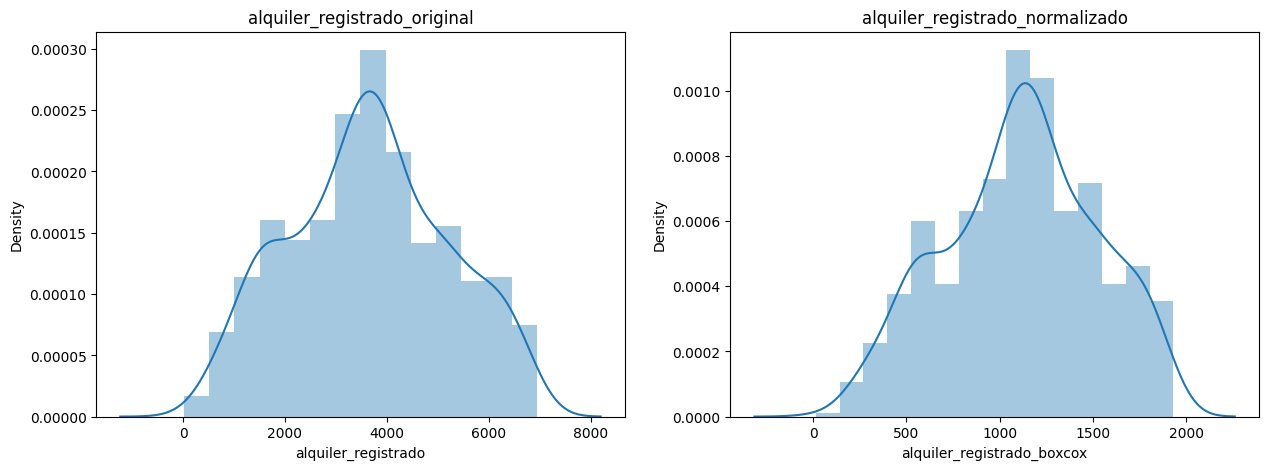

In [59]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].set_title('alquiler_registrado_original')
axes[1].set_title('alquiler_registrado_normalizado')
sns.distplot(df_bikes["alquiler_registrado"] ,ax = axes[0])
sns.distplot(df_bikes["alquiler_registrado_boxcox"], ax = axes[1]);

Con el box-cox los datos se han corregido bastante, pero siguen sin estar normalizados.

Con esta variable decidimos pasar directamente a un Decision Tree

In [60]:
# Nos quedamos con la columna 'alquiler_registrado' ya que no hemos conseguido normalizar los datos. 
# Eliminamos la columna fecha ya que no la vamos a usar.

df_bikes.drop(['alquiler_registrado_boxcox', 'alquiler_registrado_raiz', 'fecha'], axis = 1, inplace = True)
df_bikes.head()

,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,Invierno,2018,enero,0,lunes,0,2,18.18125,80.5833,10.749882,331,654,985
1,Invierno,2018,enero,0,martes,0,2,17.68695,69.6087,16.652113,131,670,801
2,Invierno,2018,enero,0,miercoles,1,1,9.47025,43.7273,16.636703,120,1229,1349
3,Invierno,2018,enero,0,jueves,1,1,10.60610,59.0435,10.739832,108,1454,1562
4,Invierno,2018,enero,0,viernes,1,1,11.46350,43.6957,12.522300,82,1518,1600


In [61]:
# guardamos
df_bikes.to_pickle("../data/bikes_reg.pkl")

In [62]:
# creamos un df y lo guardamos sin las variables roespuestas para poder predecir más adelante: 

df = pd.read_pickle("../data/bikes_reg.pkl")
df.drop(['alquiler_casual', 'alquiler_registrado', 'total_alquileres'], axis = 1, inplace = True)
df.to_pickle("../data/bikes_predicciones_reg.pkl")

In [63]:
#Lo primero que hacemos es estandarizar las variables numéricas

df_num = df.select_dtypes(include = np.number)

In [64]:
#Iniciamos el método RobustScaler y lo aplicamos
robust = RobustScaler()
robust.fit(df_num)
X_robust = robust.transform(df_num)

In [65]:
# guardamos para predicción el método de estandarización:

with open ("../data/robust_registrado.pkl", "wb") as f:
    pickle.dump(robust, f)  

In [66]:
numericas_robust = pd.DataFrame(X_robust, columns = df_num.columns)
numericas_robust.head(2)

,sensacion_termica,humedad,velocidad_viento
0,-0.456399,0.856714,-0.208909
1,-0.492863,0.332554,0.687550


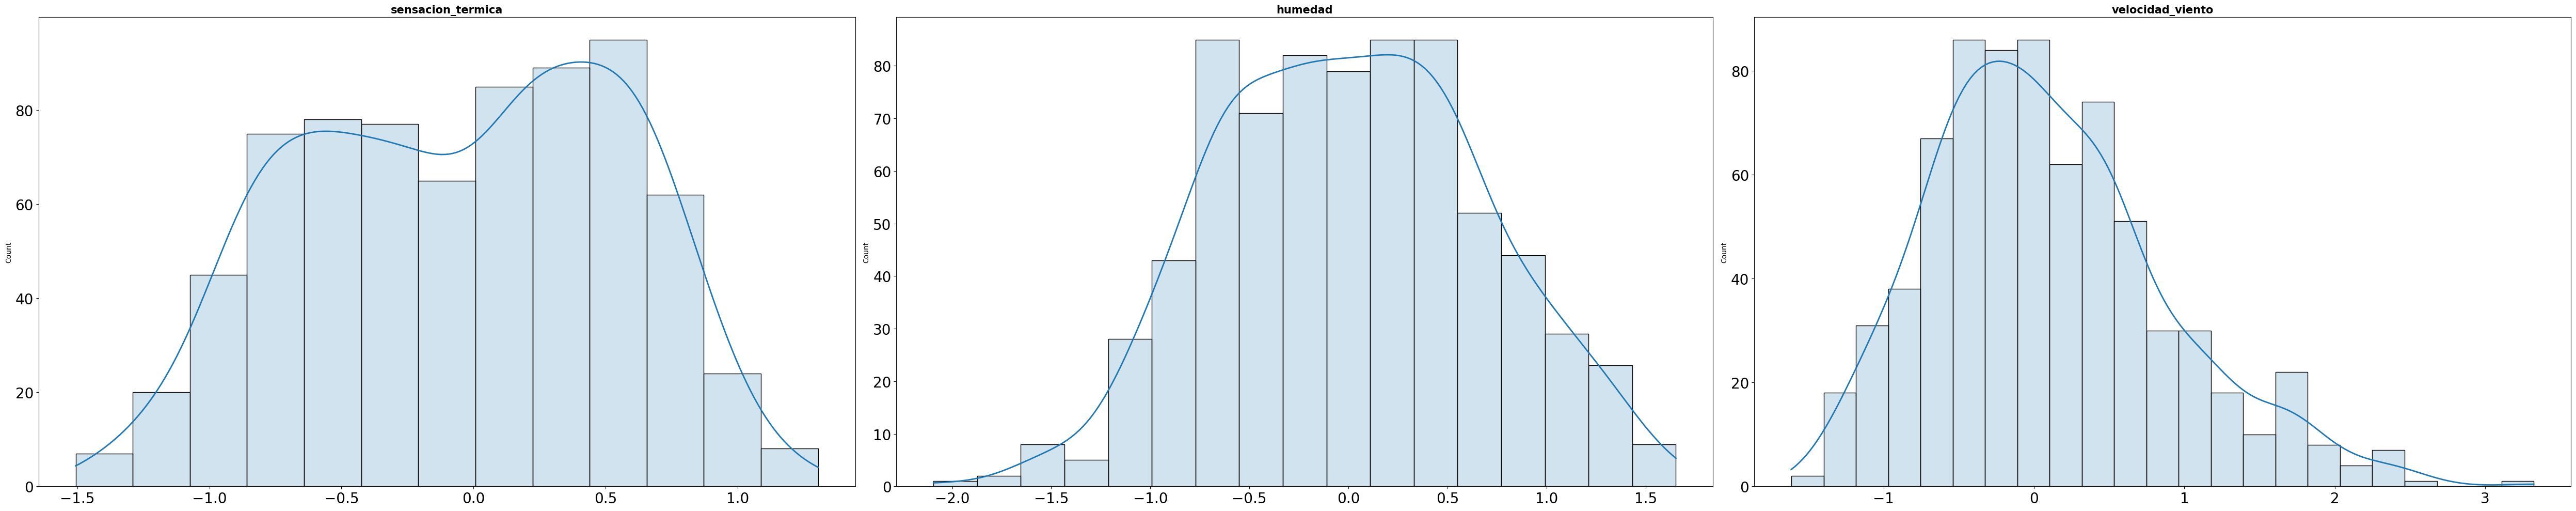

In [67]:
#Visualizamos la distribución de las variables numéricas una vez estandarizadas

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (50, 10))
columnas_robust = numericas_robust.columns
axes = axes.flat

for i, colum in enumerate(columnas_robust):
    sns.histplot(
        data = numericas_robust,
        x = colum,
        kde = True,
        line_kws = {"linewidth": 2},
        alpha = 0.2,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    
fig.tight_layout();

In [68]:
#Creamos un nuevo dataframe con las variables numéricas estandarizadas

df_est = df_num[df_num.columns] = numericas_robust
df_est.head(2)


,sensacion_termica,humedad,velocidad_viento
0,-0.456399,0.856714,-0.208909
1,-0.492863,0.332554,0.687550


Codificamos las variables categóricas

In [69]:
#Creamos un dataframe sólo con las variables categóricas

df_cat = df.select_dtypes(exclude=np.number)
df_cat.head(2)

,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo
0,Invierno,2018,enero,0,lunes,0,2
1,Invierno,2018,enero,0,martes,0,2


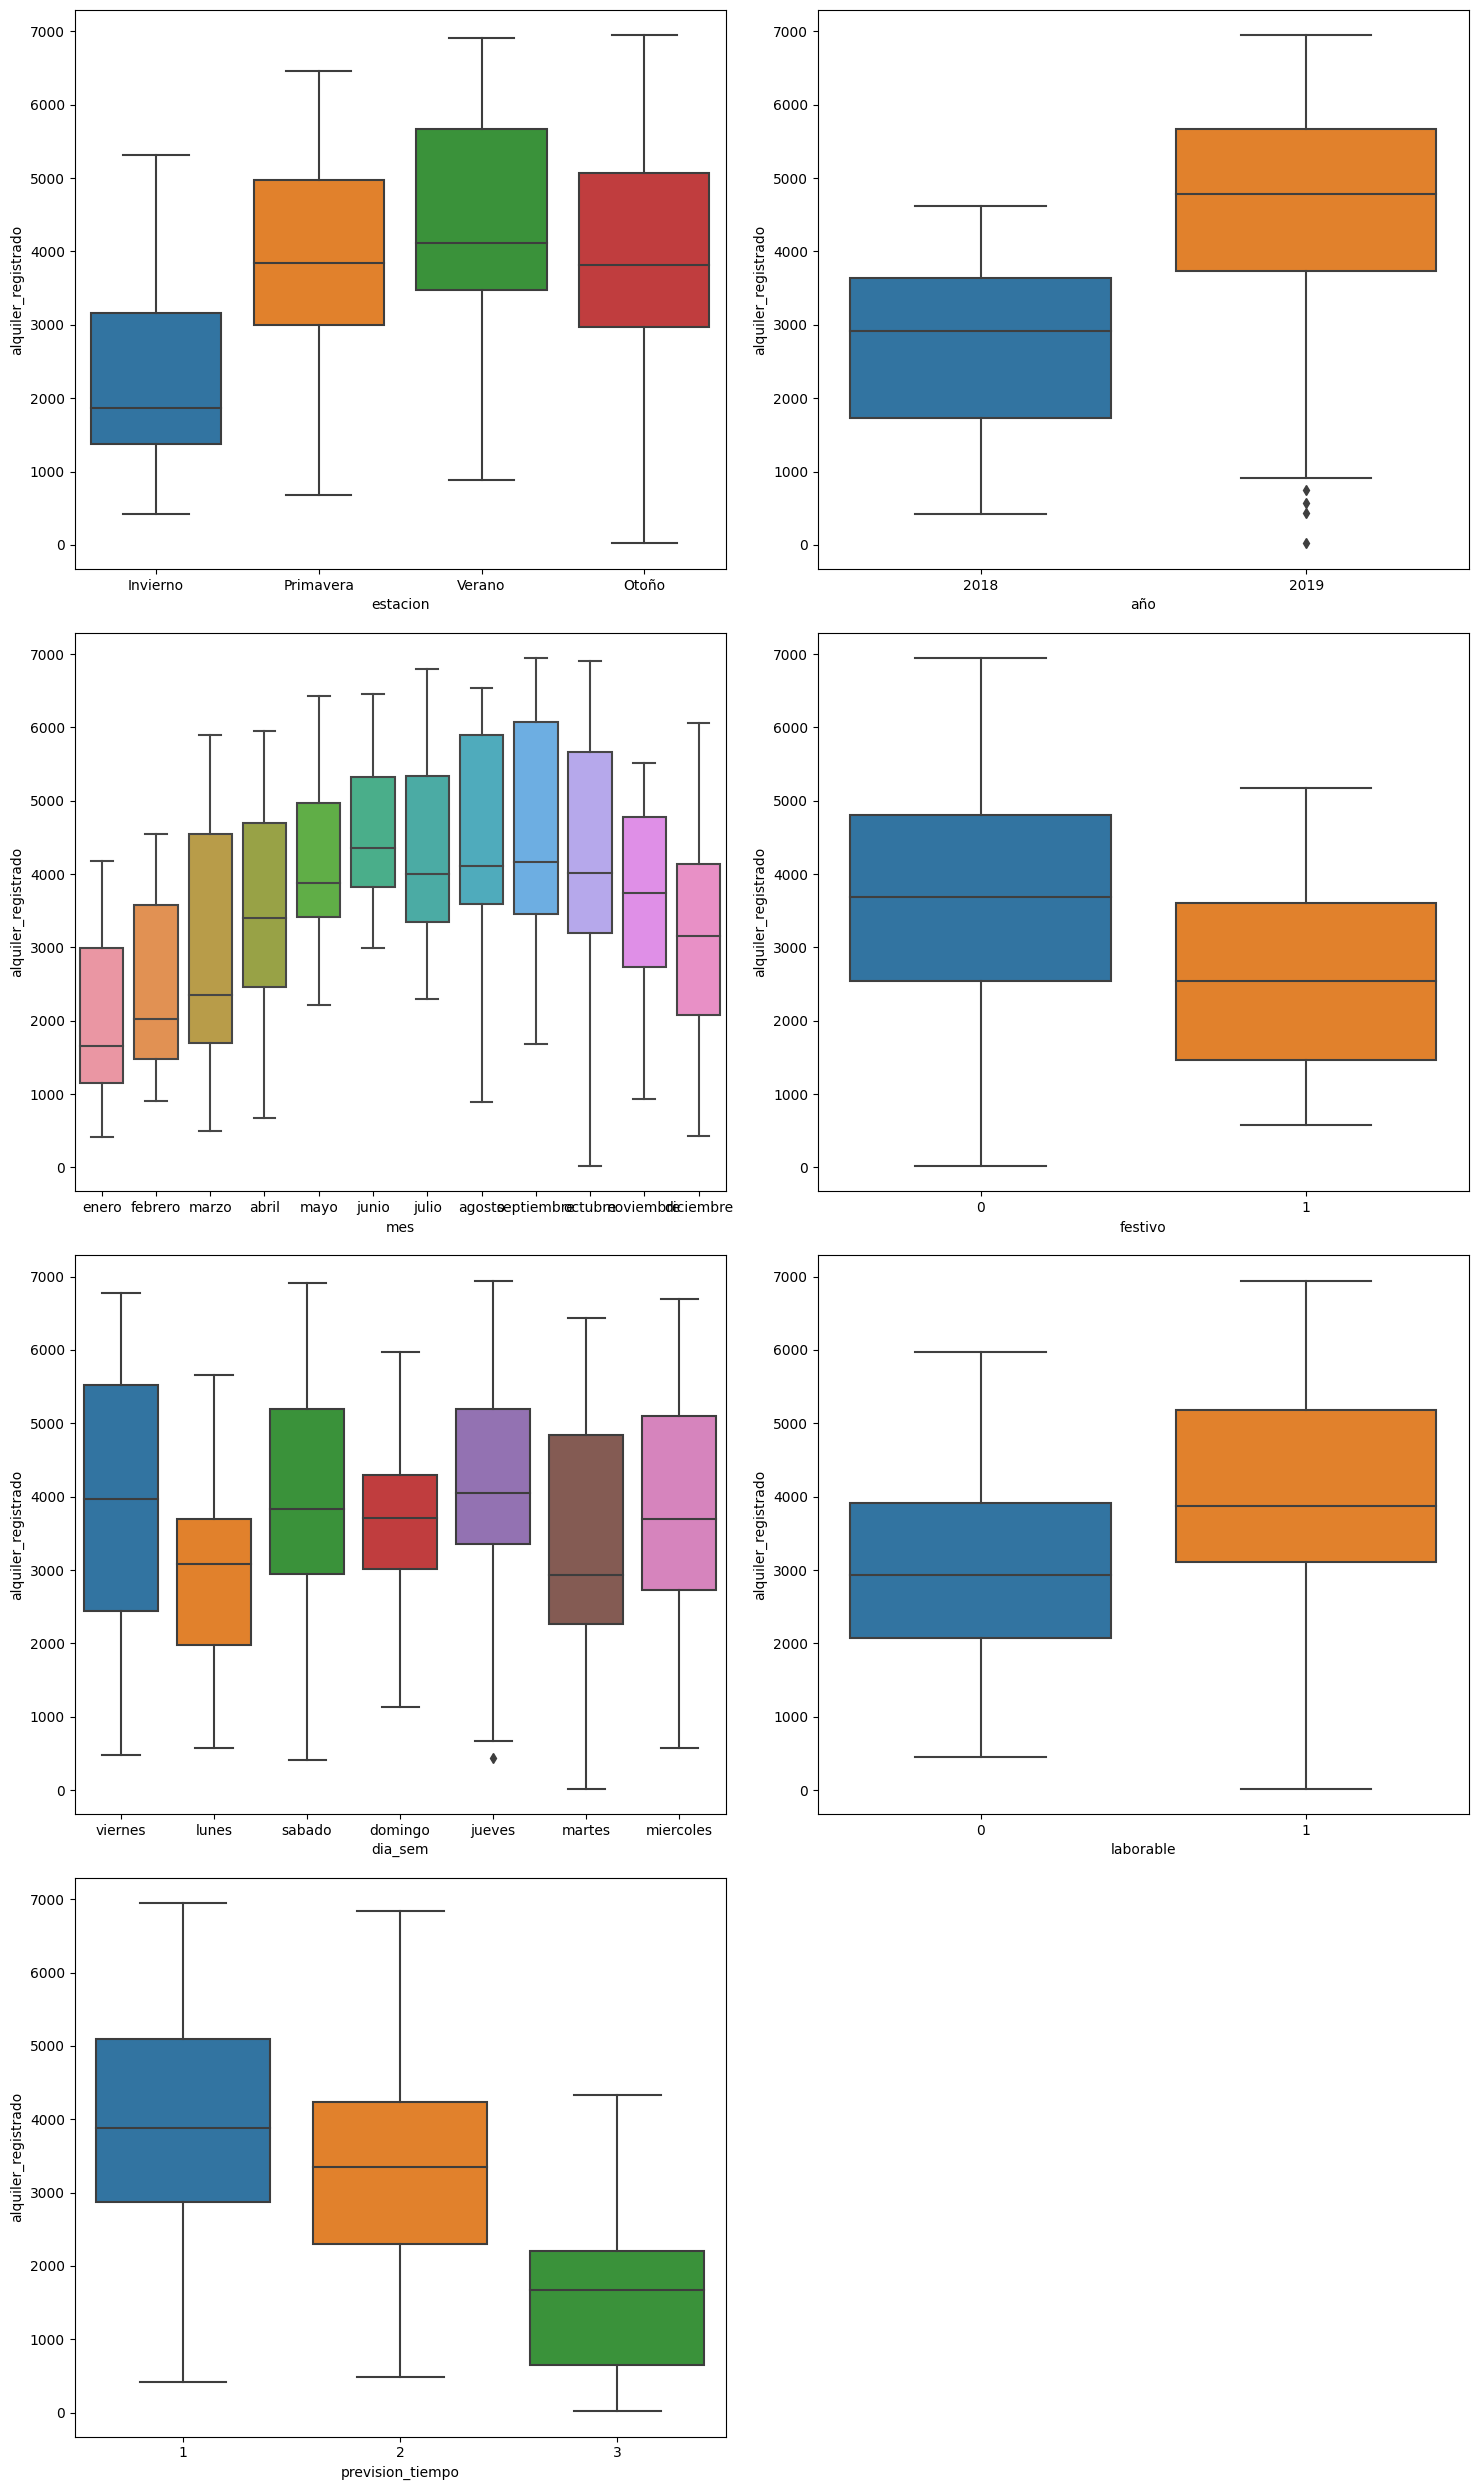

In [70]:
# sacamos boxplots para ver si las variables tienen orden:

fig, axes = plt.subplots(4, 2, figsize=(15, 25))
axes = axes.flat
lista_casual = df_cat.columns
for indice, elemento in enumerate(lista_casual):
    sns.boxplot(x = elemento, y = "alquiler_registrado", data = df_bikes, ax=axes[indice])
plt.tight_layout()
plt.delaxes(axes[-1])
plt.show();

Orden de las variables: (tomamos como referencia cada 250 puntos = 1 )
 
[{'Invierno': 0, 'Otoño':2, 'Primavera': 2.4, 'Verano': 2.2}, {'2018':0, '2019':2}, {'enero':0, 'febrero':0.5, 'marzo':1,'diciembre': 1.5,'abril': 1.7,'noviembre': 2, ,'mayo': 2.2, 'octubre':2.2, 'abril': 2, 'julio':2.2, 'septiembre':2.5, 'agosto':2.5, 'junio':2.7 },
{0: 1, 1:0},
{'miercoles':1, 'jueves':1.3, 'viernes':1.3, 'sabado':1, 'martes':0, 'lunes': 0, 'domingo':1}, {0:0, 1:1}, {3:0, 2:2, 1:2.5}]

In [71]:
#Lo primero que tenemos que hacer es resetear los índices de df, ya que hemos eliminado algunos registros

df = df.reset_index(drop= True)

In [72]:
#creamos los diccionarios con el orden que queremos establecer

lista_dict_reg = [{'Invierno': 0, 'Otoño':2, 'Primavera': 2.4, 'Verano': 2.2}, {'2018':0, '2019':2}, {'enero':0, 'febrero':0.5, 'marzo':1,'diciembre': 1.5,'abril': 1.7,'noviembre': 2, 'mayo': 2.2, 'octubre':2.2, 'abril': 2, 'julio':2.2, 'septiembre':2.5, 'agosto':2.5, 'junio':2.7 },
{0: 1, 1:0},
{'miercoles':1, 'jueves':1.3, 'viernes':1.3, 'sabado':1, 'martes':0, 'lunes': 0, 'domingo':1}, {0:0, 1:1}, {3:0, 2:2, 1:2.5}]

#creamos una lista con las columnas que tienen orden
lista_col = df_cat.columns


In [73]:
#Usamos map para codificar las columnas que tienen orden
#creamos un dataframe vacío para ir añadiendo las columnas codificadas
df_enco = pd.DataFrame()

for dic, col in zip(lista_dict_reg, lista_col):   
    
    df_enco[f'{col}_map'] = df[col].map(dic)
    
df_enco.head(2)

,estacion_map,año_map,mes_map,festivo_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,0.0,0,0.0,1,0.0,0,2.0
1,0.0,0,0.0,1,0.0,0,2.0


## revisar a partir de aqui

In [74]:
for col in df_enco.columns:
    print(df_enco[col].unique())
    print('-------------------------')

[0.  2.4 2.2 2. ]
-------------------------
[0, 2]
Categories (2, int64): [0, 2]
-------------------------
[0.  0.5 1.  2.  2.2 2.7 2.5 1.5]
-------------------------
[1, 0]
Categories (2, int64): [1, 0]
-------------------------
[0.  1.  1.3]
-------------------------
[0, 1]
Categories (2, int64): [0, 1]
-------------------------
[2.0, 2.5, 0.0]
Categories (3, float64): [2.5, 2.0, 0.0]
-------------------------


In [75]:
#unimos los dataframes de las variables numéricas estandarizadas con el dataframe de las variables categóricas codificadas

df_estenc = pd.concat([numericas_robust, df_enco], axis=1)
df_estenc.head()

,sensacion_termica,humedad,velocidad_viento,estacion_map,año_map,mes_map,festivo_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,-0.456399,0.856714,-0.208909,0.0,0,0.0,1,0.0,0,2.0
1,-0.492863,0.332554,0.687550,0.0,0,0.0,1,0.0,0,2.0
2,-1.098990,-0.903573,0.685210,0.0,0,0.0,1,1.0,1,2.5
3,-1.015201,-0.172053,-0.210435,0.0,0,0.0,1,1.3,1,2.5
4,-0.951952,-0.905082,0.060294,0.0,0,0.0,1,1.3,1,2.5


In [76]:
#guardamos el dataframe

df_estenc.to_csv('../data/df_estand_encod_reg.csv')

Decision Tree:

In [77]:
# dividimos en dos dataframes: x(predictoras) e y (variable respuesta)
# creamos los 4 grupos (train-test)
 
x= df_estenc
y = df_bikes["alquiler_registrado"]

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [78]:
# instanciamos el método y lo ajustamos:

arbol_registrado = DecisionTreeRegressor(random_state =0)
arbol_registrado.fit(x_train_reg, y_train_reg)

DecisionTreeRegressor(random_state=0)

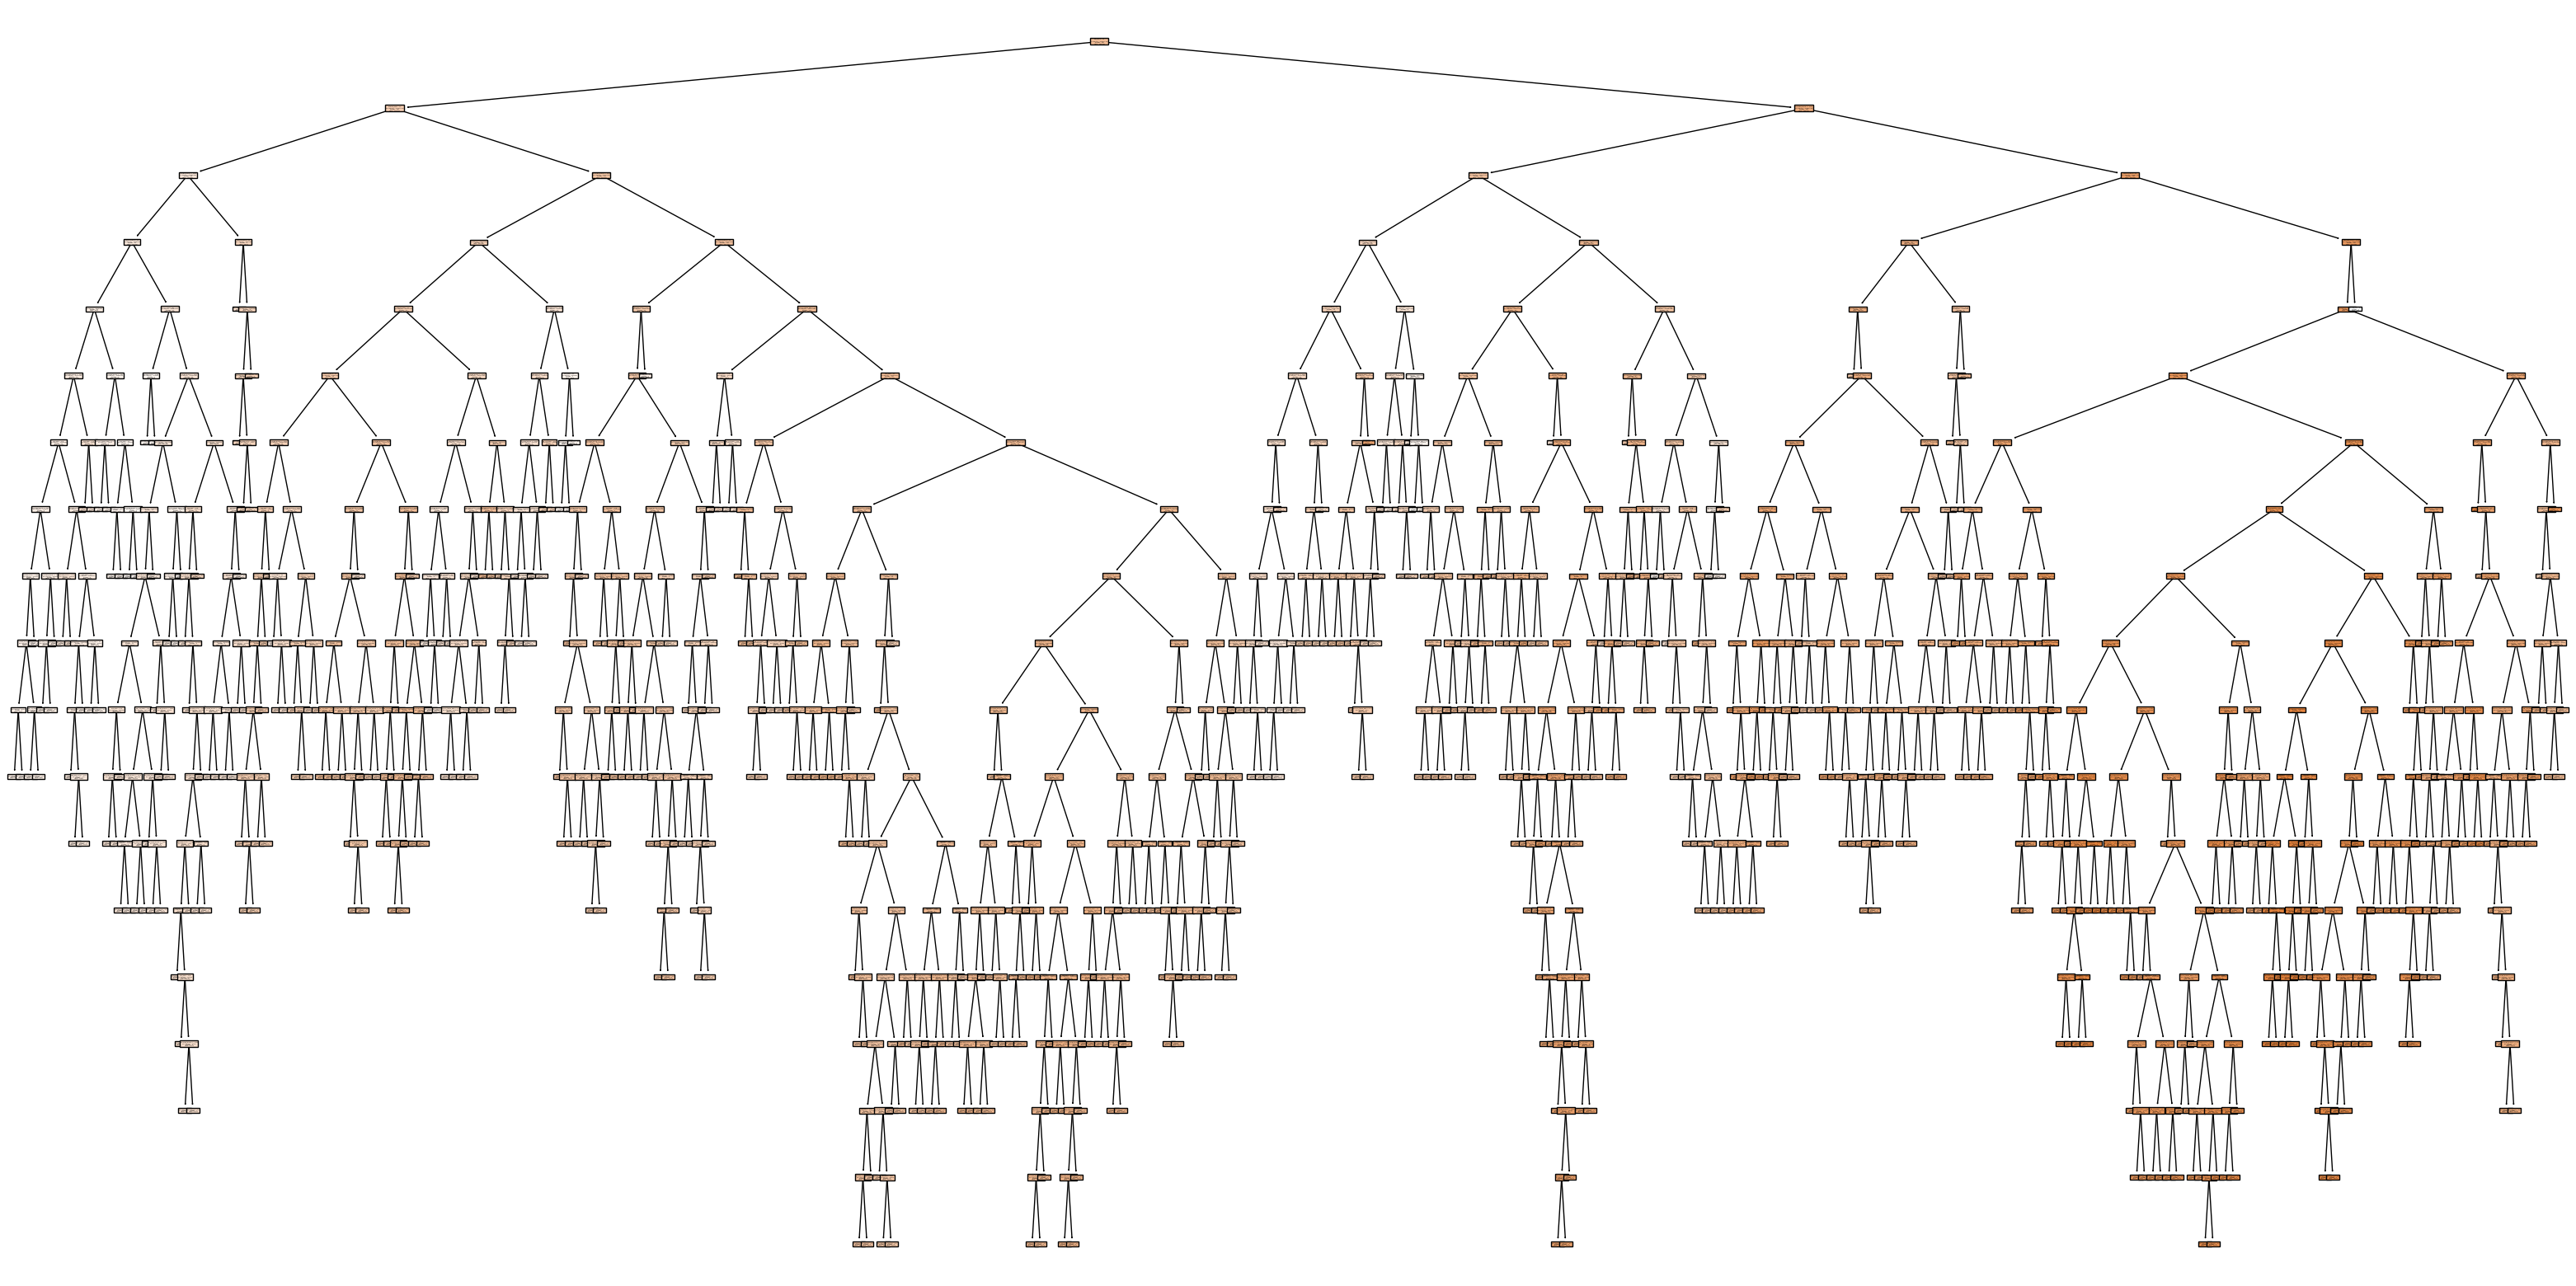

In [79]:
# imprimimos:

fig = plt.figure(figsize = (40, 20))
tree.plot_tree(arbol_registrado, feature_names = list(x_train_reg.columns), filled = True);

In [80]:
# calculamos la profundidad y la raíz cuadrada de las variables:

print(arbol_registrado.tree_.max_depth)
print("___________")
max_features = np.sqrt(len(x_train_reg.columns))
max_features

18
___________


3.1622776601683795

In [81]:
y_pred_test_registrado = arbol_registrado.predict(x_test_reg)
y_pred_train_registrado = arbol_registrado.predict(x_train_reg)

In [82]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """con esta función calculamos las métricas del árbol

    Args:
        y_test: datos test
        y_train: datos para entrenar
        y_test_pred: datos predichos predictoras (test)
        y_train_pred: datos predichos predictoras (entrenamiento)
        tipo_modelo: nombre que le queremos dar a nuestro modelo

    Returns:
        df: dataframe con las métricas
    """
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [83]:
arbol_registrado_resultado = metricas(y_test_reg, y_train_reg, y_pred_test_registrado, y_pred_train_registrado, "DT Casual I")
arbol_registrado_resultado

,MAE,MSE,RMSE,R2,set,modelo
0,487.191781,683562.547945,826.778415,0.683326,test,DT Casual I
1,0.000000,0.000000,0.000000,1.000000,train,DT Casual I


In [84]:
param_registrado_2 = {"max_depth": [6,8,10], # tenemos overfitting reducimos la profundidad del modelo, la nuestra anterior era de 18. 
        "max_features": [1,2,3,4],# ponemos como límite el 4 ya que el resultado de la raiz cuadrada es 3.3
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50, 100]}

In [85]:
gs_registrado = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param_registrado_2, # hiperparámetros nuevos
            cv=10, # crossvalidation 
            verbose= 0,
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

gs_registrado.fit(x_train_reg, y_train_reg)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [86]:
mejor_modelo_registrado_2 = gs_registrado.best_estimator_
mejor_modelo_registrado_2

DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

In [87]:
y_pred_test_registrado_2 = mejor_modelo_registrado_2.predict(x_test_reg)
y_pred_train_registrado_2 = mejor_modelo_registrado_2.predict(x_train_reg)

In [88]:
arbol_registrado_resultado_2 = metricas(y_test_reg, y_train_reg, y_pred_test_registrado_2, y_pred_train_registrado_2, "DT Registrado II")
arbol_registrado_resultado_2

,MAE,MSE,RMSE,R2,set,modelo
0,458.130757,375391.764573,612.692227,0.826092,test,DT Registrado II
1,490.085924,455720.481370,675.070723,0.817206,train,DT Registrado II


In [89]:
param_registrado_3 = {"max_depth": [10, 14],
        "max_features": [2,3,4],
        "min_samples_split": [50, 100],
        "min_samples_leaf": [15,20,25]}

In [90]:
gs_registrado = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param_registrado_3, 
            cv=10, 
            verbose= 0,
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_registrado.fit(x_train_reg, y_train_reg)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 14], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [15, 20, 25],
                         'min_samples_split': [50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [91]:
mejor_modelo_registrado_3 = gs_registrado.best_estimator_
mejor_modelo_registrado_3

DecisionTreeRegressor(max_depth=14, max_features=4, min_samples_leaf=20,
                      min_samples_split=50)

In [92]:
y_pred_test_registrado_3 = mejor_modelo_registrado_3.predict(x_test_reg)
y_pred_train_registrado_3 = mejor_modelo_registrado_3.predict(x_train_reg)

In [93]:
arbol_registrado_resultado_3 = metricas(y_test_reg, y_train_reg, y_pred_test_registrado_3, y_pred_train_registrado_3, "DT Registrado III")
arbol_registrado_resultado_3

,MAE,MSE,RMSE,R2,set,modelo
0,645.095791,659360.320613,812.010050,0.694539,test,DT Registrado III
1,617.168214,656174.898137,810.046232,0.736802,train,DT Registrado III


In [94]:
dt_resultados_registrado = pd.concat([arbol_registrado_resultado, arbol_registrado_resultado_2, arbol_registrado_resultado_3], axis = 0)
dt_resultados_registrado

,MAE,MSE,RMSE,R2,set,modelo
0,487.191781,683562.547945,826.778415,0.683326,test,DT Casual I
1,0.000000,0.000000,0.000000,1.000000,train,DT Casual I
0,458.130757,375391.764573,612.692227,0.826092,test,DT Registrado II
1,490.085924,455720.481370,675.070723,0.817206,train,DT Registrado II
0,645.095791,659360.320613,812.010050,0.694539,test,DT Registrado III
1,617.168214,656174.898137,810.046232,0.736802,train,DT Registrado III


Creamos un Random Forest:

Como ya tenemos creadas las variables, vamos directamente a crear el bosque

In [95]:
param_rf_registrado = {"max_depth": [11, 12],
        "max_features": [7, 8],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_registrado = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_registrado,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_registrado.fit(x_train_reg, y_train_reg)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [11, 12], 'max_features': [7, 8],
                         'min_samples_leaf': [56, 57],
                         'min_samples_split': [11, 12], 'n_estimators': [100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [96]:
bosque_registrado = gs_rf_registrado.best_estimator_
bosque_registrado

RandomForestRegressor(max_depth=12, max_features=7, min_samples_leaf=56,
                      min_samples_split=12)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:01<?, ?it/s]


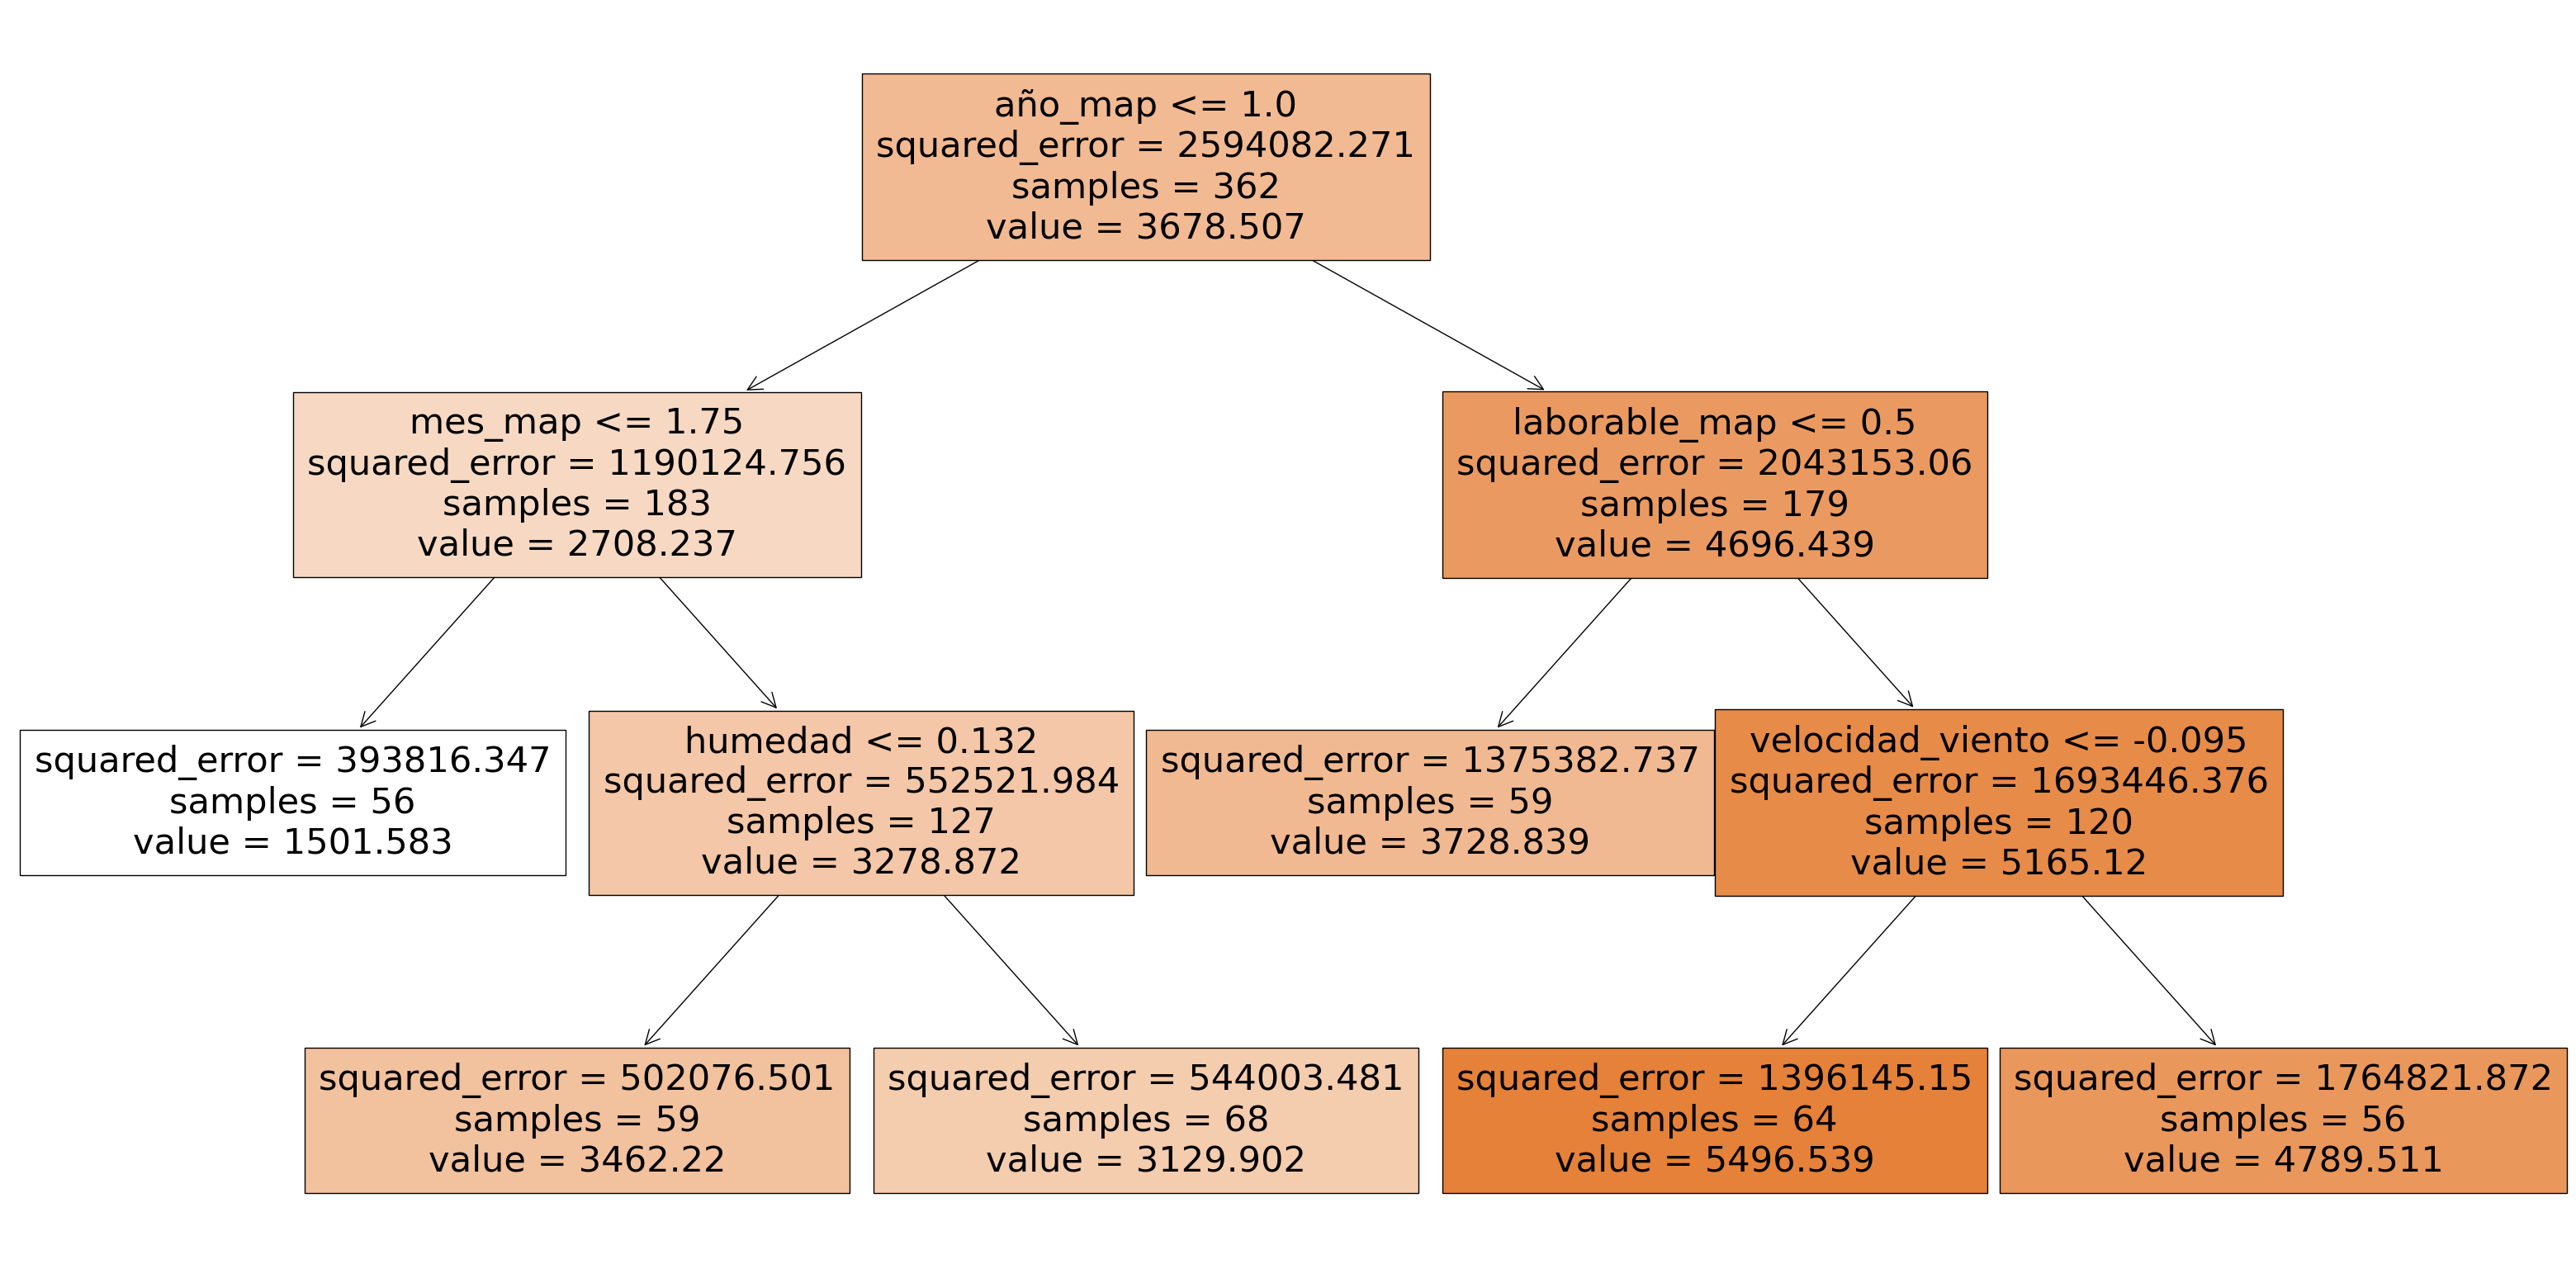

In [97]:
for arbol in tqdm(bosque_registrado):
    fig = plt.figure(figsize=(40, 20))
    tree.plot_tree(arbol, feature_names= list(x_train_reg.columns), filled = True)
    plt.savefig("../graficas/random_forest_registrado.png");
    break

In [98]:
y_pred_test_rf = bosque_registrado.predict(x_test_reg)
y_pred_train_rf = bosque_registrado.predict(x_train_reg)

results_forest_registrado = metricas(y_test_reg, y_train_reg, y_pred_test_rf, y_pred_train_rf, "RF Registrado I")
results_forest_registrado

,MAE,MSE,RMSE,R2,set,modelo
0,673.409866,699460.091262,836.337307,0.675962,test,RF Registrado I
1,713.914893,806443.784071,898.022151,0.676527,train,RF Registrado I


In [99]:
param_rf_registrado = {"max_depth": [25,30,35,],
        "max_features": [3,4,5],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_registrado = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_registrado,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 



gs_rf_registrado.fit(x_train_reg, y_train_reg)
bosque_registrado = gs_rf_registrado.best_estimator_
bosque_registrado

RandomForestRegressor(max_depth=25, max_features=5, min_samples_leaf=56,
                      min_samples_split=11)

In [100]:
y_pred_test_rf_2 = bosque_registrado.predict(x_test_reg)
y_pred_train_rf_2 = bosque_registrado.predict(x_train_reg)

results_forest_registrado_2 = metricas(y_test_reg, y_train_reg, y_pred_test_rf_2, y_pred_train_rf_2, "RF Registrado II")
results_forest_registrado_2

,MAE,MSE,RMSE,R2,set,modelo
0,711.326445,700174.188086,836.764117,0.675631,test,RF Registrado II
1,720.743777,792419.030118,890.179212,0.682153,train,RF Registrado II


In [101]:
param_rf_registrado = {"max_depth": [30, 35, 38],
        "max_features": [4,5,6],
        "min_samples_split": [15, 20],
        "min_samples_leaf": [55, 58, 60],
        "n_estimators": [100]}

gs_rf_registrado = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_registrado,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 



gs_rf_registrado.fit(x_train_reg, y_train_reg)
bosque_registrado = gs_rf_registrado.best_estimator_
bosque_registrado

RandomForestRegressor(max_depth=38, max_features=6, min_samples_leaf=55,
                      min_samples_split=20)

In [102]:
y_pred_test_rf_3 = bosque_registrado.predict(x_test_reg)
y_pred_train_rf_3 = bosque_registrado.predict(x_train_reg)

results_forest_registrado_3 = metricas(y_test_reg, y_train_reg, y_pred_test_rf_3, y_pred_train_rf_3, "RF Registrado III")
results_forest_registrado_3

,MAE,MSE,RMSE,R2,set,modelo
0,675.433588,668795.038231,817.798898,0.690168,test,RF Registrado III
1,709.260167,789371.758051,888.465958,0.683375,train,RF Registrado III


In [103]:
rf_resultados_registrado = pd.concat([results_forest_registrado, results_forest_registrado_2, results_forest_registrado_3], axis = 0)
rf_resultados_registrado

,MAE,MSE,RMSE,R2,set,modelo
0,673.409866,699460.091262,836.337307,0.675962,test,RF Registrado I
1,713.914893,806443.784071,898.022151,0.676527,train,RF Registrado I
0,711.326445,700174.188086,836.764117,0.675631,test,RF Registrado II
1,720.743777,792419.030118,890.179212,0.682153,train,RF Registrado II
0,675.433588,668795.038231,817.798898,0.690168,test,RF Registrado III
1,709.260167,789371.758051,888.465958,0.683375,train,RF Registrado III


In [104]:
resultados_alquiler_registrado = pd.concat([dt_resultados_registrado,rf_resultados_registrado], axis= 0)
resultados_alquiler_registrado.to_csv("../data/resultados_alquiler_registrado.csv")

In [105]:
resultados_alquiler_registrado

,MAE,MSE,RMSE,R2,set,modelo
0,487.191781,683562.547945,826.778415,0.683326,test,DT Casual I
1,0.000000,0.000000,0.000000,1.000000,train,DT Casual I
0,458.130757,375391.764573,612.692227,0.826092,test,DT Registrado II
1,490.085924,455720.481370,675.070723,0.817206,train,DT Registrado II
0,645.095791,659360.320613,812.010050,0.694539,test,DT Registrado III
1,617.168214,656174.898137,810.046232,0.736802,train,DT Registrado III
0,673.409866,699460.091262,836.337307,0.675962,test,RF Registrado I
1,713.914893,806443.784071,898.022151,0.676527,train,RF Registrado I
0,711.326445,700174.188086,836.764117,0.675631,test,RF Registrado II
1,720.743777,792419.030118,890.179212,0.682153,train,RF Registrado II


# CONCLUSIONES:

- El primero Decission Tree queda descartado por overfitting.

- El resto de Decision Trees tienen éxito porque el R2 supera el 0.7 aunque los resultados del test son inferiores al train.

- El mejor modelo sería el Random Forest I ya que tanto en el train como el test tenemos un R2 de 0.7. En cuanto al RMSE nos da un margen de error de 370 bicis aprox. 

In [106]:
# guardamos para predicciones:
import pickle

with open ("../data/bosque_registrado_pred.pkl", "wb") as f:
    pickle.dump(bosque_registrado, f)


Importancia de las variables:

In [107]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train_reg.columns,
                             'importancia': mejor_modelo_registrado.feature_importances_}
                            )
# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,sensacion_termica,0.380025
4,año_map,0.350732
8,laborable_map,0.083761
5,mes_map,0.050535
1,humedad,0.045895
3,estacion_map,0.045117
9,prevision_tiempo_map,0.033082
2,velocidad_viento,0.010756
7,dia_sem_map,0.000098
6,festivo_map,0.000000


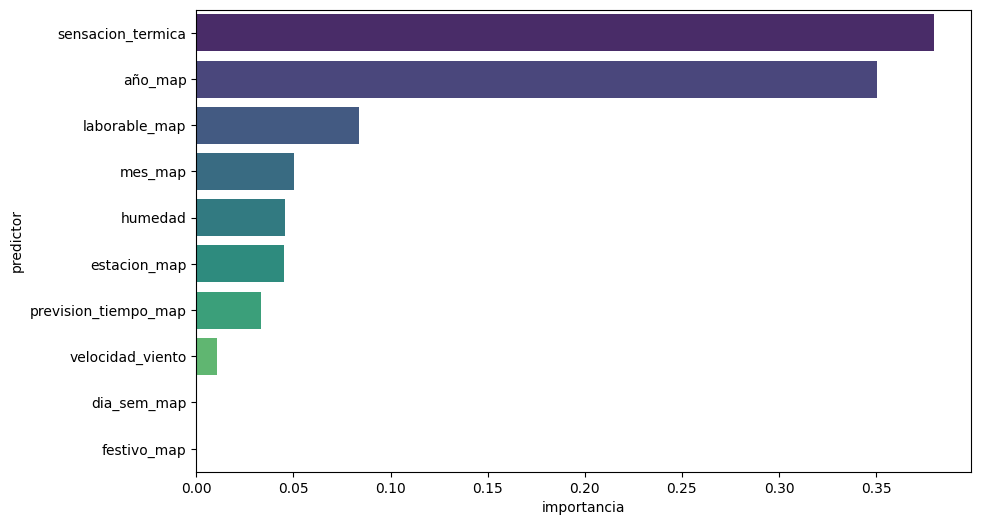

In [108]:
# por último ploteamos los resultados para verlo de una forma más amigable.
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()